In [1]:
!pip install lyapynov
import numpy as np
from numdifftools import Jacobian, Hessian
from scipy.optimize import minimize

def fun_der(x, a):
    return Jacobian(lambda x: fun(x))(x).ravel()

import lyapynov

# Continous dynamical system
continuous_system = lyapynov.ContinuousDS(x1_sol, 0, f = y1_sol, jac = fun_der(x_sol, y_sol), dt = 0.1)

# Compute maximal 1-LCE
def mLCE(system : DynamicalSystem, n_forward : int, n_compute : int, keep : bool):
    '''
    Compute the maximal 1-LCE.
        Parameters:
            system (DynamicalSystem): Dynamical system for which we want to compute the mLCE.
            n_forward (int): Number of steps before starting the mLCE computation. 
            n_compute (int): Number of steps to compute the mLCE, can be adjusted using keep_evolution.
            keep (bool): If True return a numpy array of dimension (n_compute,) containing the evolution of mLCE.
        Returns:
            mLCE (float): Maximum 1-LCE.
            history (numpy.ndarray): Evolution of mLCE during the computation.
    '''
    # Forward the system before the computation of mLCE
    system.forward(n_forward, False)
    
    # Compute the mLCE
    mLCE = 0.
    w = np.random.rand(system.dim)
    w = w / np.linalg.norm(w)
    if keep:
        history = np.zeros(n_compute)
        for i in range(1, n_compute + 1):
            w = system.next_LTM(w)
            system.forward(1, False)
            mLCE += np.log(np.linalg.norm(w))
            history[i-1] = mLCE / (i * system.dt)
            w = w / np.linalg.norm(w)
        mLCE = mLCE / (n_compute * system.dt)
        return mLCE, history
    else:
        for _ in range(n_compute):
            w = system.next_LTM(w)
            system.forward(1, False)
            mLCE += np.log(np.linalg.norm(w))
            w = w / np.linalg.norm(w)
        mLCE = mLCE / (n_compute * system.dt)
        return mLCE

Defaulting to user installation because normal site-packages is not writeable


NameError: name 'x1_sol' is not defined

In [2]:
"""
Calculate the Lyapunov exponents for a set of ODEs using the method described 
in Sandri (1996), through the use of the variational matrix.
"""

import numpy as np

def RK4(f, x, t1, t2, pf, stim=None):
    """
    Fourth-order, 4-step RK routine.
    Returns the step, i.e. approximation to the integral.
    If x is defined at time t_1, then stim should be an array of
    stimulus values at times t_1, (t_1+t_2)/2, and t_2 (i.e. at t1 and t2, as
    well as at the midpoint).

    Alternatively, stim may be a function pointer.
    """
    tmid = (t1 + t2)/2.0
    dt = t2 - t1

    if stim is None:
        pf_in_1 = pf
        pf_in_mid = pf
        pf_in_2 = pf
    else:
        try:
            # test if stim is a function
            s1 = stim(t1)
            s1, smid, s2 = (stim, stim, stim)
        except TypeError:
            #  otherwise assume stim is an array
            s1, smid, s2 = (stim[0], stim[1], stim[2])
        pf_in_1 = (pf, s1)
        pf_in_mid = (pf, smid)
        pf_in_2 = (pf, s2)

    K1 = f(t1, x, pf_in_1)
    K2 = f(tmid, x + dt*K1/2.0, pf_in_mid)
    K3 = f(tmid, x + dt*K2/2.0, pf_in_mid)
    K4 = f(t2, x + dt*K3, pf_in_2)

    return dt * (K1/2.0 + K2 + K3 + K4/2.0) / 3.0

def computeLE(f, fjac, x0, t, p=(), ttrans=None):
    """
    Computes the global Lyapunov exponents for a set of ODEs.
    f - ODE function. Must take arguments like f(t, x, p) where x and t are 
        the state and time *now*, and p is a tuple of parameters. If there are 
        no model paramters, p should be set to the empty tuple.
    x0 - Initial position for calculation. Integration of transients will begin 
         from this point.
    t - Array of times over which to calculate LE.
    p - (optional) Tuple of model parameters for f.
    fjac - Jacobian of f.
    ttrans - (optional) Times over which to integrate transient behavior.
             If not specified, assumes trajectory is on the attractor.
    method - (optional) Integration method to be used by scipy.integrate.ode.
    """
    D = len(x0)
    N = len(t)
    if ttrans is not None:
        Ntrans = len(ttrans)
    dt = t[1] - t[0]

    def dPhi_dt(t, Phi, x):
        """ The variational equation """
        D = len(x)
        rPhi = np.reshape(Phi, (D, D))
        rdPhi = np.dot(fjac(t, x, p), rPhi)
        return rdPhi.flatten()

    def dSdt(t, S, p):
        """
        Differential equations for combined state/variational matrix
        propagation. This combined state is called S.
        """
        x = S[:D]
        Phi = S[D:]
        return np.append(f(t,x,p), dPhi_dt(t, Phi, x))

    # integrate transient behavior
    Phi0 = np.eye(D, dtype=np.float64).flatten()
    #S0 = np.append(x0, Phi0)

    if ttrans is not None:
        print("Integrating transient behavior...")
        #Strans = np.zeros((Ntrans, D*(D+1)), dtype=np.float64)
        #Strans[0] = S0
        xi = x0
        for i,(t1,t2) in enumerate(zip(ttrans[:-1], ttrans[1:])):
            xip1 = xi + RK4(f, xi, t1, t2, p)
            #Strans_temp = Strans[i] + RK4(dSdt, Strans[i], t1, t2, p)
            # perform QR decomposition on Phi
            #rPhi = np.reshape(Strans_temp[D:], (D, D))
            #Q,R = np.linalg.qr(rPhi)
            #Strans[i+1] = np.append(Strans_temp[:D], Q.flatten())
            xi = xip1
        x0 = xi

        #S0 = np.append(Strans[-1, :D], Phi0)
        #S0 = Strans[-1]

    # start LE calculation
    LE = np.zeros((N-1, D), dtype=np.float64)
    Ssol = np.zeros((N, D*(D+1)), dtype=np.float64)
    #Ssol[0] = S0
    Ssol[0] = np.append(x0, Phi0)

    print("Integrating system for LE calculation...")
    for i,(t1,t2) in enumerate(zip(t[:-1], t[1:])):
        Ssol_temp = Ssol[i] + RK4(dSdt, Ssol[i], t1, t2, p)
        # perform QR decomposition on Phi
        rPhi = np.reshape(Ssol_temp[D:], (D, D))
        Q,R = np.linalg.qr(rPhi)
        Ssol[i+1] = np.append(Ssol_temp[:D], Q.flatten())
        LE[i] = np.abs(np.diag(R))

    # compute LEs
    print("Computing LE spectrum...")
    LE = np.cumsum(np.log(LE),axis=0) / np.tile(t[1:],(D,1)).T
    return LE


In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import ipywidgets as widgets
from ipywidgets import interact

# Initial values
initial_G = 1.0
initial_m1 = 1.0
initial_m2 = 1.0
initial_m3 = 1.0

# Define the equations of motion
def three_body_eq(t, y, G, m1, m2, m3):
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return [vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3]

# Function to run the animation with given values of G, m1, m2, and m3
def animate_three_body(G, m1, m2, m3):
    # Initial conditions for a periodic orbit
    x1, y1 = 0.970, 0.243
    x2, y2 = -0.970, -0.243
    x3, y3 = 0.0, 0.0
    vx1, vy1 = 0.466, -0.432
    vx2, vy2 = 0.466, -0.432
    vx3, vy3 = -2 * 0.466, 2 * 0.432
    y0 = [x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3]

    # Time span and evaluation points
    t_span = (0, 30)
    t_eval = np.linspace(*t_span, 500)  # Reduced frames for smoother rendering

    # Solving the equations
    solution = solve_ivp(three_body_eq, t_span, y0, args=(G, m1, m2, m3), t_eval=t_eval, rtol=1e-9)
    x1_sol, y1_sol = solution.y[0], solution.y[1]
    x2_sol, y2_sol = solution.y[2], solution.y[3]
    x3_sol, y3_sol = solution.y[4], solution.y[5]

    return solution

In [4]:
import numpy as np

def dPhi_dt(t, Phi, x, fjac, p):
    """ The variational equation for the Jacobian matrix. """
    D = len(x)
    rPhi = np.reshape(Phi, (D, D))  # Reshaping Phi to D x D
    rdPhi = np.dot(fjac(t, x, *p), rPhi)  # Jacobian matrix multiplied by Phi
    return rdPhi.flatten()  # Flatten back to 1D

def dSdt(t, S, f, fjac, p):
    """
    Differential equations for combined state and variational matrix.
    S is the combined state vector, consisting of [x, Phi].
    """
    D = len(S) // 2  # Dimension of the state vector x
    x = S[:D]
    Phi = S[D:]
    dxdt = f(t, x, *p)  # State equation
    dPhidt = dPhi_dt(t, Phi, x, fjac, p)  # Variational equation
    return np.append(dxdt, dPhidt)  # Combine the derivatives of x and Phi

def RK4(func, y, t1, t2, p):
    """ Runge-Kutta 4th order integration step for function `func`. """
    dt = t2 - t1
    k1 = dt * func(t1, y, *p)
    k2 = dt * func(t1 + dt / 2, y + k1 / 2, *p)
    k3 = dt * func(t1 + dt / 2, y + k2 / 2, *p)
    k4 = dt * func(t1 + dt, y + k3, *p)
    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

def computeLE(f, fjac, x0, t, p=(), ttrans=None):
    """
    Computes the global Lyapunov exponents for a set of ODEs.
    f - ODE function.
    fjac - Jacobian of f.
    x0 - Initial state for calculation.
    t - Array of times for LE computation.
    p - Parameters for f.
    ttrans - Optional transients.
    """
    D = len(x0)  # Dimension of the state vector
    N = len(t)
    dt = t[1] - t[0]
    Phi0 = np.eye(D, dtype=np.float64).flatten()  # Initial variational matrix (identity, flattened)
    LE = np.zeros((N - 1, D), dtype=np.float64)  # For storing LE values at each step
    Ssol = np.zeros((N, D * (D + 1)), dtype=np.float64)  # Combined state and variational solution
    Ssol[0] = np.append(x0, Phi0)

    # Transient behavior if ttrans is provided
    if ttrans is not None:
        xi = x0
        for t1, t2 in zip(ttrans[:-1], ttrans[1:]):
            xi += RK4(f, xi, t1, t2, p)
        x0 = xi
        Ssol[0] = np.append(x0, Phi0)

    print("Integrating system for LE calculation...")
    for i, (t1, t2) in enumerate(zip(t[:-1], t[1:])):
        Ssol_temp = Ssol[i] + RK4(lambda t, S, *p: dSdt(t, S, f, fjac, p), Ssol[i], t1, t2, p)
        
        # Ensure the size of Ssol_temp[D:] is D * D before reshaping
        if len(Ssol_temp[D:]) == D * D:
            rPhi = np.reshape(Ssol_temp[D:], (D, D))  # Reshape to D x D
        else:
            raise ValueError(f"Cannot reshape array of size {len(Ssol_temp[D:])} into shape ({D}, {D}).")
        
        Q, R = np.linalg.qr(rPhi)
        Ssol[i + 1] = np.append(Ssol_temp[:D], Q.flatten())  # Update the combined state and variational matrix
        LE[i] = np.abs(np.diag(R))  # Lyapunov exponents are the diagonal of R
        print(f"Step {i}, LE diagonal: {LE[i]}")

    LE = np.cumsum(np.log(LE), axis=0) / np.tile(t[1:], (D, 1)).T
    print("Final LE values:", LE[-1])

    return LE[-1]


In [5]:
import autograd.numpy as anp  # Use autograd's numpy equivalent
from autograd import jacobian
from scipy.integrate import solve_ivp
import numpy as np

# Define the three-body ODE system
def three_body_eq(t, y, p):
    G, m1, m2, m3 = p
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = anp.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = anp.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = anp.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return anp.array([vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3])

# Define the Jacobian function
def fjac(t, x, p):
    jac_func = jacobian(lambda x: three_body_eq(t, x, p))
    return jac_func(x)

# Placeholder function for RK4 (Runge-Kutta 4th Order method)
def RK4(f, x, t1, t2, p):
    dt = t2 - t1
    k1 = f(t1, x, p)
    k2 = f(t1 + dt/2, x + dt*k1/2, p)
    k3 = f(t1 + dt/2, x + dt*k2/2, p)
    k4 = f(t1 + dt, x + dt*k3, p)
    return dt * (k1 + 2*k2 + 2*k3 + k4) / 6

# Parameters for the three-body problem
G = 1.0  # Gravitational constant (example value)
m1, m2, m3 = 1.0, 1.0, 1.0  # Masses of the three bodies (example values)
params = (G, m1, m2, m3)  # Pack parameters in a tuple

# Initial conditions (positions and velocities)
y0 = np.array([0.970, 0.243, -0.970, -0.243, 0.5, 0.0,
               0.0, 0.466, -0.432, 0.466, -2 * 0.466, 2 * 0.432])

# Define the time span and evaluation points
t_span = (0, 30)
t_eval = np.linspace(*t_span, 500)

# Solve the ODE
solution = solve_ivp(lambda t, y: three_body_eq(t, y, params), t_span, y0, t_eval=t_eval, rtol=1e-9)
x1_sol, y1_sol = solution.y[0], solution.y[1]
x2_sol, y2_sol = solution.y[2], solution.y[3]
x3_sol, y3_sol = solution.y[4], solution.y[5]

# Now use computeLE to calculate Lyapunov exponents
exponents = computeLE(three_body_eq, fjac, x0=y0, t=t_eval, p=params)


print(exponents)

Integrating system for LE calculation...


ValueError: cannot reshape array of size 78 into shape (78,78)

In [ ]:
print(exponents[498])

Largest Lyapunov exponent: 0.44056141667792137


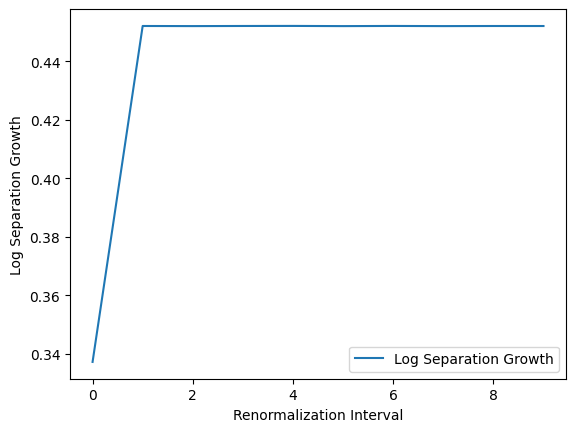

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Gravitational constant (normalized units)
G = 1

def three_body_eq(t, y, p):
    G, m1, m2, m3 = p
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = anp.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = anp.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = anp.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return anp.array([vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3])

# Initial conditions and parameters
masses = [1.0, 1.0, 1.0]
y0 = np.array([1.970, 0.243, -0.970, -0.243, 0.5, 0.0,
               0.0, 0.466, -0.432, 0.466, -2 * 0.466, 2 * 0.432])

# Integration parameters
t_span = (0, 50)
t_eval = np.linspace(*t_span, 500)

# Define a small initial perturbation and norm size
perturbation = 1e-8
num_renormalizations = 10  # How often we reset the perturbation to avoid growth limit

# Initialize arrays to store separation growth
initial_perturbation = np.random.normal(scale=perturbation, size=y0.shape)
perturbed_y0 = y0 + np.concatenate([initial_perturbation[:6], np.zeros(6)])  # Position only

# Storage for Lyapunov exponent values
lyapunov_exponent_values = []

# Iterate for renormalizations
for i in range(num_renormalizations):
    # Integrate unperturbed and perturbed system for one interval
    sol_unperturbed = solve_ivp(three_body_ode, t_span, y0, args=(masses,), t_eval=t_eval, rtol=1e-9)
    sol_perturbed = solve_ivp(three_body_ode, t_span, perturbed_y0, args=(masses,), t_eval=t_eval, rtol=1e-9)
    
    # Calculate the separation at the end of the interval
    final_separation = np.linalg.norm(sol_unperturbed.y[:6, -1] - sol_perturbed.y[:6, -1])
    lyapunov_exponent_values.append(np.log(final_separation / perturbation) / (t_span[1] - t_span[0]))

    # Renormalize the separation
    delta = (sol_perturbed.y[:6, -1] - sol_unperturbed.y[:6, -1])
    delta_normalized = perturbation * delta / np.linalg.norm(delta)
    perturbed_y0 = np.concatenate([sol_unperturbed.y[:6, -1] + delta_normalized, sol_unperturbed.y[6:, -1]])

# Average Lyapunov exponent over intervals
lyapunov_exponent = np.mean(lyapunov_exponent_values)
print(f"Largest Lyapunov exponent: {lyapunov_exponent}")

# Plot the log separation over intervals
plt.plot(np.arange(num_renormalizations), lyapunov_exponent_values, label="Log Separation Growth")
plt.xlabel("Renormalization Interval")
plt.ylabel("Log Separation Growth")
plt.legend()
plt.show()


Largest Lyapunov exponent: 0.44875458162001924


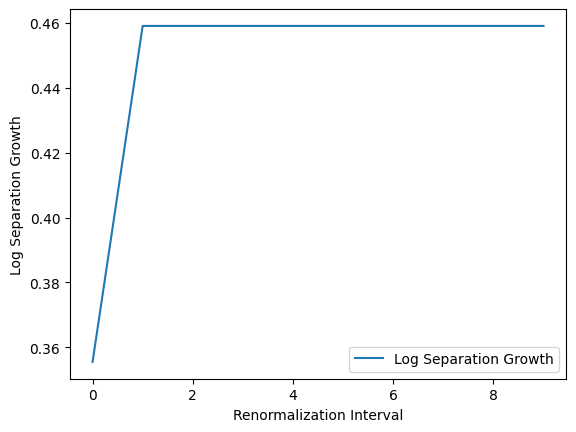

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Gravitational constant (normalized units)
G = 1

def three_body_eq(t, y, p):
    G, m1, m2, m3 = p
    x1, y1, x2, y2, x3, y3 = y[0:6]
    vx1, vy1, vx2, vy2, vx3, vy3 = y[6:12]
    r12 = anp.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r13 = anp.sqrt((x3 - x1)**2 + (y3 - y1)**2)
    r23 = anp.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    
    ax1 = G * m2 * (x2 - x1) / r12**3 + G * m3 * (x3 - x1) / r13**3
    ay1 = G * m2 * (y2 - y1) / r12**3 + G * m3 * (y3 - y1) / r13**3
    
    ax2 = G * m1 * (x1 - x2) / r12**3 + G * m3 * (x3 - x2) / r23**3
    ay2 = G * m1 * (y1 - y2) / r12**3 + G * m3 * (y3 - y2) / r23**3
    
    ax3 = G * m1 * (x1 - x3) / r13**3 + G * m2 * (x2 - x3) / r23**3
    ay3 = G * m1 * (y1 - y3) / r13**3 + G * m2 * (y2 - y3) / r23**3
    
    return anp.array([vx1, vy1, vx2, vy2, vx3, vy3, ax1, ay1, ax2, ay2, ax3, ay3])

# Initial conditions and parameters
masses = [1.0, 1.0, 1.0]
y0 = np.array([0.970, 0.243, -0.970, -0.243, 0.5, 0.0,
               0.0, 0.466, -0.432, 0.466, -2 * 0.466, 2 * 0.432])

# Integration parameters
t_span = (0, 50)
t_eval = np.linspace(*t_span, 500)

# Define a small initial perturbation and norm size
perturbation = 1e-8
num_renormalizations = 10  # How often we reset the perturbation to avoid growth limit

# Initialize arrays to store separation growth
initial_perturbation = np.random.normal(scale=perturbation, size=y0.shape)
perturbed_y0 = y0 + np.concatenate([initial_perturbation[:6], np.zeros(6)])  # Position only

# Storage for Lyapunov exponent values
lyapunov_exponent_values = []

# Iterate for renormalizations
for i in range(num_renormalizations):
    # Integrate unperturbed and perturbed system for one interval
    sol_unperturbed = solve_ivp(three_body_ode, t_span, y0, args=(masses,), t_eval=t_eval, rtol=1e-9)
    sol_perturbed = solve_ivp(three_body_ode, t_span, perturbed_y0, args=(masses,), t_eval=t_eval, rtol=1e-9)
    
    # Calculate the separation at the end of the interval
    final_separation = np.linalg.norm(sol_unperturbed.y[:6, -1] - sol_perturbed.y[:6, -1])
    lyapunov_exponent_values.append(np.log(final_separation / perturbation) / (t_span[1] - t_span[0]))

    # Renormalize the separation
    delta = (sol_perturbed.y[:6, -1] - sol_unperturbed.y[:6, -1])
    delta_normalized = perturbation * delta / np.linalg.norm(delta)
    perturbed_y0 = np.concatenate([sol_unperturbed.y[:6, -1] + delta_normalized, sol_unperturbed.y[6:, -1]])

# Average Lyapunov exponent over intervals
lyapunov_exponent = np.mean(lyapunov_exponent_values)
print(f"Largest Lyapunov exponent: {lyapunov_exponent}")

# Plot the log separation over intervals
plt.plot(np.arange(num_renormalizations), lyapunov_exponent_values, label="Log Separation Growth")
plt.xlabel("Renormalization Interval")
plt.ylabel("Log Separation Growth")
plt.legend()
plt.show()
